Bloc 0  : init

In [1]:
# --- BLOC 0 : Initialisation chemins + MLflow (version simple et stable) ---
import mlflow
from pathlib import Path

# 🔹 Chemins en dur selon ta structure
DATA_DIR  = Path("../data")
PROC_DIR  = DATA_DIR / "processed"
MODEL_DIR = DATA_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# 🔹 MLflow local
mlflow.set_tracking_uri("file:../mlruns")          # le dossier mlruns sera à la racine du projet
mlflow.set_experiment("rakuten_xgb_fusion")

print("✅ MLflow initialisé sur ../mlruns")
print("📁 Dossiers :")
print(" - Data :", DATA_DIR.resolve())
print(" - Processed :", PROC_DIR.resolve())
print(" - Models :", MODEL_DIR.resolve())


2025/11/04 11:30:28 INFO mlflow.tracking.fluent: Experiment with name 'rakuten_xgb_fusion' does not exist. Creating a new experiment.


✅ MLflow initialisé sur ../mlruns
📁 Dossiers :
 - Data : /home/marc/programme/nlp/xboost/data
 - Processed : /home/marc/programme/nlp/xboost/data/processed
 - Models : /home/marc/programme/nlp/xboost/data/models


🧹 Bloc 1 — Data cleaning → X_train_prepro.csv

In [2]:
# --- BLOC 1 : Nettoyage texte ---
import pandas as pd, re, html, os
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import mlflow

with mlflow.start_run(run_name="clean_data"):
    X = pd.read_csv("../data/X_train_update.csv")
    Y = pd.read_csv("../data/Y_train_CVw08PX.csv", usecols=["prdtypecode"])
    df = X.copy()
    df["label"] = Y["prdtypecode"]

    def clean_text(text):
        if not isinstance(text, str):
            return ""
        text = BeautifulSoup(text, "html.parser").get_text(" ")
        text = html.unescape(text)
        text = re.sub(r"[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s]", " ", text)
        text = re.sub(r"\s+", " ", text).strip().lower()
        return text

    tqdm.pandas(desc="🧹 Nettoyage texte")
    df["text"] = (
        df["designation"].fillna("") + " " + df["description"].fillna("")
    ).progress_apply(clean_text)

    out_path = "../data/X_train_prepro.csv"
    df[["productid", "imageid", "text", "label"]].to_csv(out_path, index=False)

    mlflow.log_metric("rows_cleaned", len(df))
    mlflow.log_artifact(out_path, artifact_path="clean_data")

print("✅ data/X_train_prepro.csv :", df.shape)


🧹 Nettoyage texte:   0%|          | 0/84916 [00:00<?, ?it/s]

✅ data/X_train_prepro.csv : (84916, 7)


In [ ]:
🔤 Bloc 2 — TF-IDF (sparse) → X_text_sparse.npz + tfidf_vectorizer.joblib + y.npy

In [3]:
# --- BLOC 2 : TF-IDF avec split + logging MLflow ---
import pandas as pd, numpy as np, joblib, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from scipy import sparse
import mlflow

with mlflow.start_run(run_name="tfidf_features"):
    # 1️⃣ Chargement
    df = pd.read_csv("../data/X_train_prepro.csv")
    print(f"✅ Lignes : {len(df)}")

    # 2️⃣ Split avant le fit
    X_train_text, X_val_text, y_train, y_val = train_test_split(
        df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
    )

    # 3️⃣ Fit TF-IDF sur train
    tfidf = TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        sublinear_tf=True,
        min_df=2
    )
    print("🔤 Fit TF-IDF (train)...")
    X_train_tfidf = tfidf.fit_transform(tqdm(X_train_text))
    X_val_tfidf   = tfidf.transform(tqdm(X_val_text))

    # 4️⃣ Sauvegarde
    os.makedirs("../data/processed", exist_ok=True)
    sparse.save_npz("../data/processed/X_train_text_sparse.npz", X_train_tfidf)
    sparse.save_npz("../data/processed/X_val_text_sparse.npz", X_val_tfidf)
    np.save("../data/processed/y_train.npy", y_train)
    np.save("../data/processed/y_val.npy", y_val)
    joblib.dump(tfidf, "../data/processed/tfidf_vectorizer.joblib")

    # 5️⃣ Logging MLflow
    mlflow.log_params({
        "max_features": 20000,
        "ngram_range": "(1,2)",
        "sublinear_tf": True,
        "min_df": 2
    })
    mlflow.log_metrics({
        "train_shape_1": X_train_tfidf.shape[1],
        "vocab_size": len(tfidf.vocabulary_)
    })
    mlflow.log_artifact("../data/processed/tfidf_vectorizer.joblib", artifact_path="tfidf")

print("✅ TF-IDF terminé et sauvegardé.")


✅ Lignes : 84916
🔤 Fit TF-IDF (train)...


  0%|          | 0/67932 [00:00<?, ?it/s]

  0%|          | 0/16984 [00:00<?, ?it/s]

✅ TF-IDF terminé et sauvegardé.


🖼️ Bloc 3 — Embeddings images (ResNet50) → X_img.npy

In [4]:
# --- BLOC 3 : Extraction d'embeddings ResNet50 ---
import torch, os, numpy as np, pandas as pd
from torch import nn
from torchvision import models, transforms
from PIL import Image
from tqdm.auto import tqdm
import mlflow

with mlflow.start_run(run_name="resnet_embeddings"):
    CSV_PATH = "../data/X_train_prepro.csv"
    IMG_DIR  = "../data/images/images/image_train"
    OUT_PATH = "../data/processed/X_img.npy"

    df = pd.read_csv(CSV_PATH)
    image_ids = df["imageid"].astype(str).tolist()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    resnet.fc = nn.Identity()
    resnet.eval().to(device)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

    batch_size = 32
    feats = []
    for i in tqdm(range(0, len(image_ids), batch_size), desc="🧠 ResNet50 embeddings"):
        batch_tensors = []
        for iid in image_ids[i:i+batch_size]:
            path = os.path.join(IMG_DIR, f"{iid}.jpg")
            try:
                img = Image.open(path).convert("RGB")
                x = preprocess(img)
            except Exception:
                x = torch.zeros(3,224,224)
            batch_tensors.append(x)
        xb = torch.stack(batch_tensors).to(device)
        with torch.no_grad():
            emb = resnet(xb).cpu().numpy().reshape(len(batch_tensors), -1)
        feats.append(emb)

    X_img = np.vstack(feats).astype(np.float32)
    os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
    np.save(OUT_PATH, X_img)
    print("✅ X_img:", X_img.shape, "→", OUT_PATH)

    # Logging MLflow
    mlflow.log_param("model", "resnet50_imagenet")
    mlflow.log_metric("n_images", len(image_ids))
    mlflow.log_metric("embedding_dim", X_img.shape[1])
    mlflow.log_artifact(OUT_PATH, artifact_path="embeddings")


🧠 ResNet50 embeddings:   0%|          | 0/2654 [00:00<?, ?it/s]

✅ X_img: (84916, 2048) → ../data/processed/X_img.npy


🔗 Bloc 4 — Fusion texte+image → X_all_sparse.npz

In [6]:
# --- BLOC 4 : Fusion TF-IDF + embeddings (train / val séparés) ---
from scipy import sparse
import numpy as np
import mlflow, os

with mlflow.start_run(run_name="fusion_features"):
    print("📦 Chargement des features texte et image...")

    # Chargement des features texte
    X_train_text = sparse.load_npz("../data/processed/X_train_text_sparse.npz")
    X_val_text   = sparse.load_npz("../data/processed/X_val_text_sparse.npz")

    # Chargement des embeddings image
    X_img = np.load("../data/processed/X_img.npy")
    n_total = X_img.shape[0]

    print(f"✅ Texte train: {X_train_text.shape}, val: {X_val_text.shape}, images: {X_img.shape}")

    # Hypothèse : les lignes images sont dans le même ordre que le dataset global
    # Donc on découpe X_img selon la même proportion 80/20
    n_train = X_train_text.shape[0]
    X_img_train = X_img[:n_train]
    X_img_val   = X_img[n_train:n_total]

    # Conversion en CSR
    X_img_train_csr = sparse.csr_matrix(X_img_train)
    X_img_val_csr   = sparse.csr_matrix(X_img_val)

    # Fusion horizontale (texte + image)
    X_train_all = sparse.hstack([X_train_text, X_img_train_csr]).tocsr()
    X_val_all   = sparse.hstack([X_val_text,   X_img_val_csr]).tocsr()

    # Sauvegardes
    os.makedirs("../data/processed", exist_ok=True)
    sparse.save_npz("../data/processed/X_train_all_sparse.npz", X_train_all)
    sparse.save_npz("../data/processed/X_val_all_sparse.npz",   X_val_all)

    print("💾 Sauvegardes :")
    print(" - ../data/processed/X_train_all_sparse.npz :", X_train_all.shape)
    print(" - ../data/processed/X_val_all_sparse.npz   :", X_val_all.shape)

    # Logging MLflow
    mlflow.log_metric("train_shape_0", X_train_all.shape[0])
    mlflow.log_metric("train_shape_1", X_train_all.shape[1])
    mlflow.log_metric("val_shape_0", X_val_all.shape[0])
    mlflow.log_metric("val_shape_1", X_val_all.shape[1])
    mlflow.log_artifact("../data/processed/X_train_all_sparse.npz", artifact_path="fusion")
    mlflow.log_artifact("../data/processed/X_val_all_sparse.npz", artifact_path="fusion")

print("✅ Fusion TF-IDF + Image terminée.")


📦 Chargement des features texte et image...
✅ Texte train: (67932, 20000), val: (16984, 20000), images: (84916, 2048)
💾 Sauvegardes :
 - ../data/processed/X_train_all_sparse.npz : (67932, 22048)
 - ../data/processed/X_val_all_sparse.npz   : (16984, 22048)
✅ Fusion TF-IDF + Image terminée.


🧠 Bloc 5 — Entraînement XGBoost (progress bar) → modèles + métriques

In [7]:
# --- BLOC 5 : Entraînement XGBoost avec MLflow tracking ---
import numpy as np, os, json, joblib, xgboost as xgb
from scipy import sparse
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.auto import tqdm
import mlflow, mlflow.xgboost

with mlflow.start_run(run_name="train_xgb_fusion"):
    # === 1️⃣ Chargement des features pré-fusionnées ===
    X_train = sparse.load_npz("../data/processed/X_train_all_sparse.npz")
    X_val   = sparse.load_npz("../data/processed/X_val_all_sparse.npz")
    y_train = np.load("../data/processed/y_train.npy")
    y_val   = np.load("../data/processed/y_val.npy")

    print(f"📦 X_train: {X_train.shape}, X_val: {X_val.shape}")
    print(f"📊 y_train: {y_train.shape}, y_val: {y_val.shape}")

    # === 2️⃣ Encodage des labels ===
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    y_train_enc = encoder.fit_transform(y_train)
    y_val_enc   = encoder.transform(y_val)

    dtrain = xgb.DMatrix(X_train, label=y_train_enc)
    dval   = xgb.DMatrix(X_val,   label=y_val_enc)

    # === 3️⃣ Paramètres XGBoost ===
    params = {
        "objective": "multi:softprob",
        "num_class": len(np.unique(y_train_enc)),
        "eval_metric": ["mlogloss", "merror"],
        "eta": 0.1,
        "max_depth": 8,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "tree_method": "hist",
    }
    mlflow.log_params(params)

    # === 4️⃣ Entraînement avec barre de progression ===
    class TQDMProgress(xgb.callback.TrainingCallback):
        def __init__(self, total): self.pbar = tqdm(total=total, desc="🧠 Training")
        def after_iteration(self, model, epoch, evals_log):
            self.pbar.update(1)
            tr = evals_log["train"]["mlogloss"][-1]; va = evals_log["val"]["mlogloss"][-1]
            self.pbar.set_postfix({"train": f"{tr:.4f}", "val": f"{va:.4f}"})
            return False
        def after_training(self, model): self.pbar.close(); return model

    num_round = 200
    evals_result = {}
    os.makedirs("../data/models", exist_ok=True)

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=[(dtrain, "train"), (dval, "val")],
        evals_result=evals_result,
        verbose_eval=False,
        callbacks=[TQDMProgress(num_round)],
    )

    # === 5️⃣ Évaluation ===
    y_pred = np.argmax(bst.predict(dval), axis=1)
    acc = accuracy_score(y_val_enc, y_pred)
    f1  = f1_score(y_val_enc, y_pred, average="weighted")

    print(f"✅ Accuracy: {acc:.4f} | F1: {f1:.4f}")
    print("=== Rapport (résumé) ===")
    print(classification_report(y_val_enc, y_pred, digits=3)[:1000])

    mlflow.log_metrics({"accuracy": float(acc), "f1": float(f1)})

    # === 6️⃣ Sauvegardes locales ===
    model_path = "../data/models/xgb_fusion.json"
    enc_path   = "../data/models/label_encoder.joblib"
    metrics_path = "../data/models/metrics_fusion.json"

    bst.save_model(model_path)
    joblib.dump(encoder, enc_path)
    json.dump({"accuracy": float(acc), "f1": float(f1)}, open(metrics_path, "w"))

    print("💾 Modèle:", model_path, "| Encodeur:", enc_path)

    # === 7️⃣ Logging MLflow des artefacts ===
    mlflow.xgboost.log_model(bst, artifact_path="xgb_model")
    mlflow.log_artifact(enc_path, artifact_path="preprocessing")
    mlflow.log_artifact(metrics_path, artifact_path="metrics")

print("✅ Entraînement XGBoost terminé et tracé dans MLflow.")


📦 X_train: (67932, 22048), X_val: (16984, 22048)
📊 y_train: (67932,), y_val: (16984,)


🧠 Training:   0%|          | 0/200 [00:00<?, ?it/s]

2025/11/04 12:18:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Accuracy: 0.8065 | F1: 0.8095
=== Rapport (résumé) ===
              precision    recall  f1-score   support

           0      0.374     0.608     0.463       623
           1      0.754     0.588     0.661       502
           2      0.843     0.812     0.827       336
           3      0.986     0.825     0.898       166
           4      0.774     0.762     0.768       534
           5      0.918     0.882     0.900       791
           6      0.794     0.529     0.635       153
           7      0.736     0.744     0.740       974
           8      0.650     0.548     0.595       414
           9      0.947     0.931     0.939      1009
          10      0.961     0.925     0.943       161
          11      0.885     0.739     0.805       498
          12      0.778     0.730     0.753       648
          13      0.835     0.836     0.836      1015
          14      0.918     0.922     0.920       861
          15      0.877     0.752     0.809       161
          16      0.786 

/home/marc/miniconda3/envs/nlp/lib/python3.11/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [12:18:18] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/11/04 12:18:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Entraînement XGBoost terminé et tracé dans MLflow.


📊 Bloc 6 — Matrice de confusion (affichage uniquement)

In [8]:
# --- BLOC 6 : Matrice de confusion + Logging MLflow (jeu de validation) ---
# ⚙️ Prérequis : seaborn matplotlib pandas xgboost scikit-learn joblib tqdm

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os
import joblib, xgboost as xgb
from scipy import sparse
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
import mlflow

with mlflow.start_run(run_name="confusion_matrix_eval"):
    # === 1️⃣ Chargement des artefacts ===
    print("📦 Chargement du modèle et du jeu de validation...")
    X_val = sparse.load_npz("../data/processed/X_val_all_sparse.npz")
    y_val = np.load("../data/processed/y_val.npy")

    encoder = joblib.load("../data/models/label_encoder.joblib")
    bst = xgb.Booster()
    bst.load_model("../data/models/xgb_fusion.json")

    # === 2️⃣ Prédiction ===
    print("🔮 Prédiction sur le jeu de validation...")
    dval = xgb.DMatrix(X_val)
    y_pred = np.argmax(bst.predict(dval), axis=1)
    y_true = encoder.transform(y_val)

    # === 3️⃣ Mapping prdtypecode → noms lisibles ===
    cat_map = {
        10: "Livres culturels",
        40: "Jeux vidéo & accessoires",
        50: "Accessoires gaming",
        60: "Consoles rétro",
        1140: "Figurines Pop & geek",
        1160: "Cartes à collectionner",
        1180: "Wargames & figurines",
        1280: "Jouets enfants & bébés",
        1281: "Jeux & loisirs enfants",
        1300: "Drones & modèles réduits",
        1301: "Chaussettes enfants",
        1302: "Jouets créatifs",
        1320: "Puériculture & bébé",
        1560: "Mobilier & maison",
        1920: "Linge & déco textile",
        1940: "Alimentation & boissons",
        2060: "Décoration saisonnière",
        2220: "Accessoires animaux",
        2280: "Magazines anciens",
        2403: "Livres & partitions",
        2462: "Lots jeux & consoles",
        2522: "Papeterie",
        2582: "Mobilier de jardin",
        2583: "Accessoires piscines",
        2585: "Outils jardinage",
        2705: "Essais & Histoire",
        2905: "Jeux PC & éditions spéciales",
    }

    prdcodes = encoder.classes_
    names = [cat_map.get(int(c), str(c)) for c in prdcodes]

    # === 4️⃣ Matrice de confusion ===
    print("📊 Calcul de la matrice de confusion...")
    cm = confusion_matrix(y_true, y_pred, normalize="true")

    plt.figure(figsize=(18, 14))
    sns.heatmap(cm, cmap="Blues", xticklabels=names, yticklabels=names, cbar=True)
    plt.title("Matrice de confusion normalisée (Validation – XGBoost fusion TF-IDF + Image)", fontsize=14)
    plt.xlabel("Prédit", fontsize=12)
    plt.ylabel("Réel", fontsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # === 5️⃣ Sauvegarde + log MLflow ===
    os.makedirs("../data/plots", exist_ok=True)
    cm_path = "../data/plots/confusion_matrix_val.png"
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    mlflow.log_artifact(cm_path, artifact_path="evaluation")
    mlflow.log_metric("n_classes", len(names))
    print(f"✅ Matrice de confusion sauvegardée : {cm_path}")


📦 Chargement du modèle et du jeu de validation...
🔮 Prédiction sur le jeu de validation...
📊 Calcul de la matrice de confusion...
✅ Matrice de confusion sauvegardée : ../data/plots/confusion_matrix_val.png


📊 Affichage de la matrice de confusion : ../data/plots/confusion_matrix_val.png


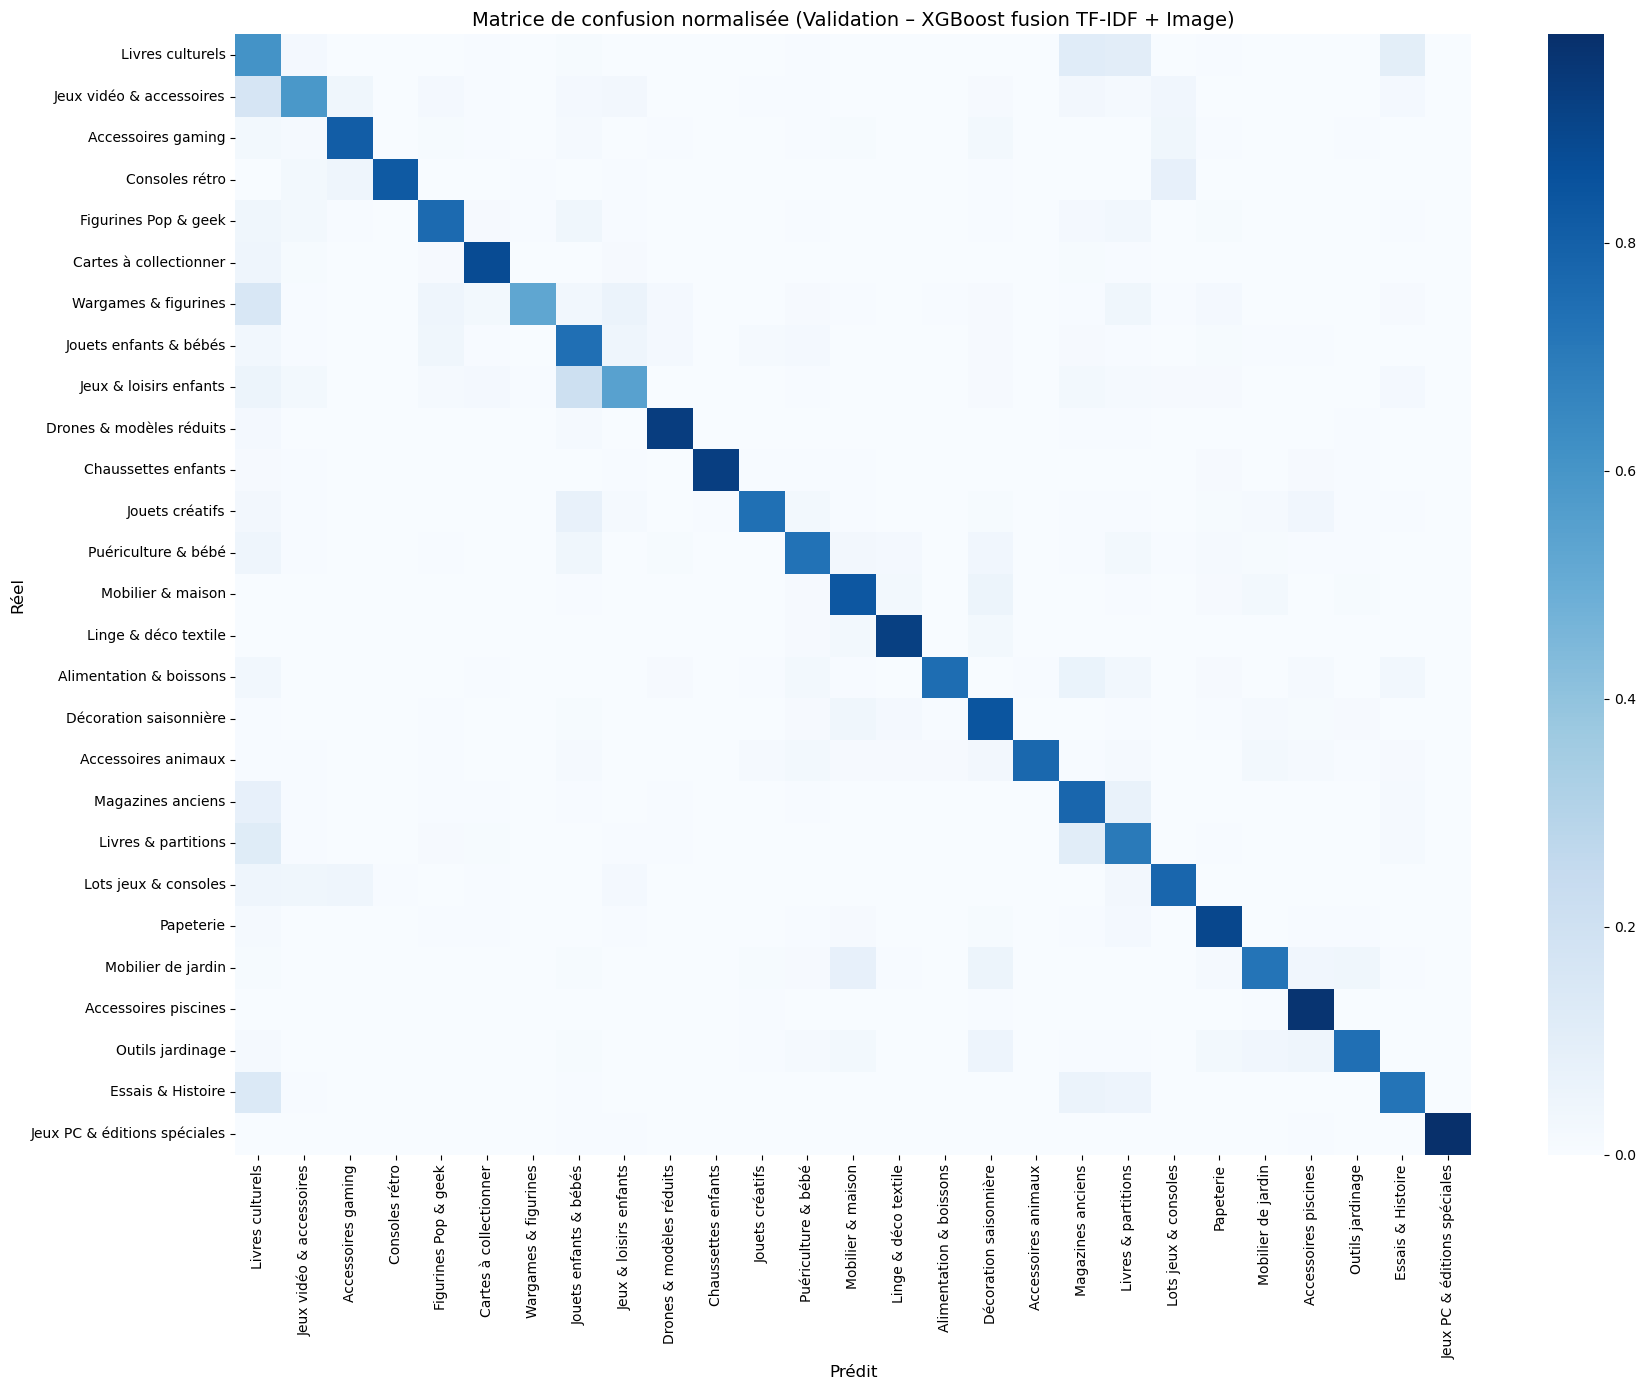

In [9]:
from IPython.display import Image, display

cm_path = "../data/plots/confusion_matrix_val.png"

# Vérifie d'abord que le fichier existe
import os
if os.path.exists(cm_path):
    print(f"📊 Affichage de la matrice de confusion : {cm_path}")
    display(Image(filename=cm_path))
else:
    print("❌ Fichier introuvable :", cm_path)


In [ ]:
# --- BLOC 7 : Mini-Grid Search XGBoost + MLflow (CPU optimisé) ---
import numpy as np, os, joblib, xgboost as xgb
from scipy import sparse
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import mlflow, mlflow.xgboost
from sklearn.preprocessing import LabelEncoder

# === 1️⃣ Chargement des données préparées ===
X_train = sparse.load_npz("../data/processed/X_train_all_sparse.npz")
X_val   = sparse.load_npz("../data/processed/X_val_all_sparse.npz")
y_train = np.load("../data/processed/y_train.npy")
y_val   = np.load("../data/processed/y_val.npy")

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)

dtrain = xgb.DMatrix(X_train, label=y_train_enc)
dval   = xgb.DMatrix(X_val,   label=y_val_enc)

# === 2️⃣ Grille d’hyperparamètres réduite ===
param_grid = {
    "max_depth": [6, 8],
    "eta": [0.1, 0.2],
}
num_round = 50

# === 3️⃣ Callback de progression ===
class TQDMProgress(xgb.callback.TrainingCallback):
    def __init__(self, total): self.pbar = tqdm(total=total, desc="🧠 Training")
    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        tr = evals_log["train"]["mlogloss"][-1]; va = evals_log["val"]["mlogloss"][-1]
        self.pbar.set_postfix({"train": f"{tr:.4f}", "val": f"{va:.4f}"})
        return False
    def after_training(self, model): self.pbar.close(); return model

# === 4️⃣ Boucle d’expérimentation ===
for depth in param_grid["max_depth"]:
    for lr in param_grid["eta"]:
        print(f"\n🚀 Entraînement : max_depth={depth}, eta={lr}")
        with mlflow.start_run(run_name=f"xgb_depth{depth}_eta{lr}"):

            params = {
                "objective": "multi:softprob",
                "num_class": len(np.unique(y_train_enc)),
                "eval_metric": ["mlogloss", "merror"],
                "eta": lr,
                "max_depth": depth,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "tree_method": "hist",
            }
            mlflow.log_params(params)

            bst = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=num_round,
                evals=[(dtrain, "train"), (dval, "val")],
                early_stopping_rounds=10,  # ⏱ stop si pas d’amélioration
                verbose_eval=False,
                callbacks=[TQDMProgress(num_round)],
            )

            # === 5️⃣ Évaluation ===
            y_pred = np.argmax(bst.predict(dval), axis=1)
            acc = accuracy_score(y_val_enc, y_pred)
            f1  = f1_score(y_val_enc, y_pred, average="weighted")

            print(f"✅ Résultat : F1={f1:.4f} | Acc={acc:.4f}")
            mlflow.log_metrics({"accuracy": float(acc), "f1": float(f1)})

            # === 6️⃣ Sauvegarde modèle + artefacts ===
            model_name = f"xgb_depth{depth}_eta{lr}.json"
            model_path = f"../data/models/{model_name}"
            bst.save_model(model_path)
            mlflow.log_artifact(model_path, artifact_path="models")

print("\n✅ Mini grid-search terminée ! Vérifie les runs dans MLflow UI.")



🚀 Entraînement : max_depth=6, eta=0.1


🧠 Training:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Résultat : F1=0.7712 | Acc=0.7638

🚀 Entraînement : max_depth=6, eta=0.2


🧠 Training:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Résultat : F1=0.7840 | Acc=0.7784

🚀 Entraînement : max_depth=8, eta=0.1


🧠 Training:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Résultat : F1=0.7792 | Acc=0.7731

🚀 Entraînement : max_depth=8, eta=0.2


🧠 Training:   0%|          | 0/50 [00:00<?, ?it/s]